In [96]:
#%matplotlib widget

# The potential of the electromagnetic induction method to monitor temperature changes in the near-surface

## Maria Carrizo, Dieter Werthmüller, and Evert Slob
Delft University of Technology, Faculty of Civil Engineering and Geosciences , Department of Applied Geophysics and Petrophysics, Delft, Netherlands (m.e.carrizomascarell@tudelft.nl)

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from empymod import filters
import pygimli as pg
import matplotlib.tri as tri
import sys
sys.path.insert(1, 'src')

# Load function that performs global search in lookup table
from EM1D import EMf_2Lay_HVP, GlobalSearch_2Lay, EMf_2Lay_Opt_HVP, ErrorSpace_2Lay

## EM Induction 

For the models data is simulated for an EMI device with the following characteristics
  - Frequency: 9000 Hz
  - Geometries: Horizontal coplanar (H) with offsets [2 m, 4 m, 8 m], Vertical coplanar (V) with offsets [2 m, 4 m, 8 m], and Perpendicular (P) with offsets [2.1 m, 4.1 m, 8.1 m]
  - Data obtained: vector with the Quadrature (Q) and In-phase (IP) components of the measurements for the H, V and P coil orientations as [Q_H2, Q_H4, Q_H8, Q_V2, Q_V4, Q_V8, Q_P2, Q_P4, Q_P8, IP_H2, IP_H4, IP_H8, IP_V2, IP_V4, IP_V8, IP_P2, IP_P4, IP_P8]

## Inversion feasibility for 2-layered EC models

Here, we evaluate the information content in the EMI measurements to determine 1D 2-layered and 3-layered EC models

Assuming 2-layered EC models the model parameters would be a model $m$ vector:

\begin{equation}
    m = [\sigma_1, \sigma_2, h_1],
\end{equation}

where $\sigma_1$ is the EC of the first layer, $\sigma_2$ is the electrical conductivity of the second layer and
$h_1$ is the thickness of the first layer

We use the method discussed in [Carrizo et. al., 2023](10.3997/2214-4609.202320049) to generate Lookup tables and perform a global search to estimate a 2-layered model.

The lookup table was generated using `1_LUTable2Lay.py` and stored in `Lookup_Tables/2Lay`. The global search will find the best data fit in the lookup table indicating the best fitting model.

In [98]:
# Settings for measurements simulations

# Define hankel filter
filt = filters.key_201_2012() 

# Define EMI instrument geometry
offsets = np.array([2, 4, 8]) # in meters
height = 0.10 # meters height from ground surface to center of coils
freq = 9000 # Frequency in Hz
# Lambda numbers
lambd = filt.base/offsets[:,np.newaxis] 

In [99]:
# Load lookup table and sampling ranges used
LU_2Lay = np.load('Lookup_Tables/2Lay/LUTable_2Lay.npy')
conds = np.load('Lookup_Tables/2Lay/conds.npy')
thicks = np.load('Lookup_Tables/2Lay/thicks.npy')
# number of samples
nsl = len(conds)

#model_est_2Lay = GlobalSearch_2Lay(LU_2Lay, data_base, conds, thicks, nsl)

In [100]:
# Generate a 2 layered model and simulate EMI measurements

sigma_1 = 10/1000 # S/m
sigma_2 = 350/1000 # S/m
h1 = 4.4 # m

model_2Lay_true =  ([sigma_1, sigma_2, h1])
data_2Lay_true = EMf_2Lay_HVP(lambd, sigma_1, sigma_2, h1, height, offsets, freq, filt)

In [101]:
# Perform inversion with global search

model_2Lay_est = GlobalSearch_2Lay(LU_2Lay, data_2Lay_true, conds, thicks, nsl)
data_2Lay_est = EMf_2Lay_HVP(lambd, 
                             sigma1 = model_2Lay_est[0],
                             sigma2 = model_2Lay_est[1],
                             h1 = model_2Lay_est[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

15/04/24 - 22:49:22 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


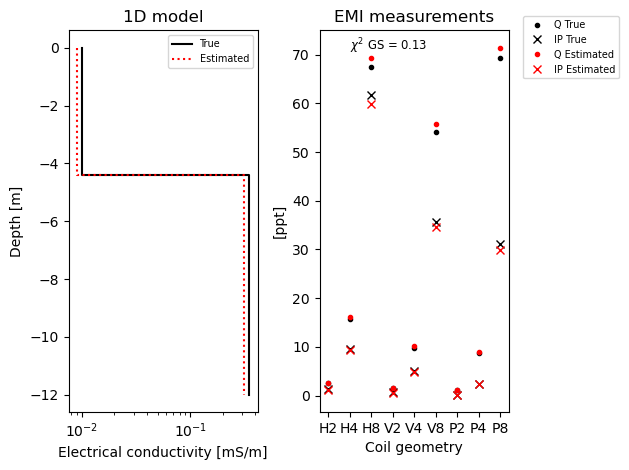

In [104]:
# Plot 1D 2-layered model

def PlotModelData(model, depths, data, ax=None, model_name='', model_style='k', data_style='b', data_name=''):
    if ax is None:
        fig, ax = plt.subplots(1,2)
    fs=7
    ax[0].step(model, depths, model_style, label=model_name)
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Electrical conductivity [mS/m]')
    ax[0].set_ylabel('Depth [m]')
    ax[0].legend(fontsize=fs)
    ax[0].set_title('1D model')

    ax[1].plot(data[:9]*1000, '.',c=data_style, label='Q '+data_name)
    ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax[1].set_xticklabels(['H2', 'H4', 'H8', 'V2', 'V4', 'V8', 'P2', 'P4', 'P8'])
    ax[1].plot(data[9:]*1000, 'x', c=data_style, label = 'IP '+data_name)
    ax[1].set_xlabel('Coil geometry')
    ax[1].legend(fontsize=fs, bbox_to_anchor=(1.05, 1.05))
    ax[1].set_title('EMI measurements')
    ax[1].set_ylabel('[ppt]')

    plt.tight_layout()
    
def rmse(y_obs, y_pred):
    L2 = np.sqrt(np.sum(((y_obs-y_pred)/y_obs)**2))
    return L2
    
dmax = -12
sigma_2Lay_true_plot = np.hstack((model_2Lay_true[:2], model_2Lay_true[1]))
depths_2Lay_true_plot = np.array([0, -h1, dmax])

sigma_2Lay_est_plot = np.hstack((model_2Lay_est[:2], model_2Lay_est[1]))
depths_2Lay_est_plot = np.array([0, -model_2Lay_est[2], dmax])

fig, ax = plt.subplots(1,2)

PlotModelData(sigma_2Lay_true_plot, depths_2Lay_true_plot, data_2Lay_true, model_name='True', data_name='True',
             ax=ax, data_style='k')
PlotModelData(sigma_2Lay_est_plot, depths_2Lay_true_plot, data_2Lay_est, model_name='Estimated', 
              data_name='Estimated', ax=ax, model_style=':r', data_style='r')
ax[1].text(1, 71, '$\chi^2$ GS = '+ "{:1.2f}".format(rmse(data_2Lay_true, data_2Lay_est)), fontsize='small')

plt.savefig('figures/2Lay_Model', format='eps')

The 2-layered EC model is accurately estimated, but how can noise affect the estimations?
We can evaluate the error space:

In [105]:
def NoiseAnalysis_2Lay(data_true, noise=0.1, test_it=100):
    
    models = []
    for i in range(test_it):
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        models.append(GlobalSearch_2Lay(LU_2Lay, data_noise, conds, thicks, nsl))
    return models
        
models_noise = NoiseAnalysis_2Lay(data_2Lay_true)

15/04/24 - 22:54:16 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


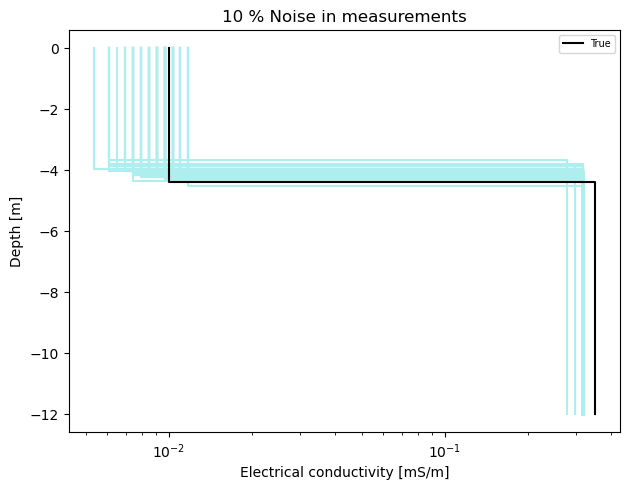

In [106]:
# Plot the models

def PlotModel(model, depths, ax=None, model_name=None, model_style='k'):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    ax.step(model, depths, model_style, label=model_name)
    ax.set_xscale('log')
    ax.set_xlabel('Electrical conductivity [mS/m]')
    ax.set_ylabel('Depth [m]')
    if model_name is not None:
        ax.legend(fontsize=fs)
    plt.tight_layout()

fig, ax = plt.subplots()

for m in range(len(models_noise)):
    mod = models_noise[m]
    sigma_2Lay_plot = np.hstack((mod[:2], mod[1]))
    depths_2Lay_plot = np.array([0, -mod[2], dmax])
    PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style='paleturquoise')
PlotModel(sigma_2Lay_true_plot, depths_2Lay_true_plot, model_name='True', ax=ax)

plt.title('10 % Noise in measurements') 
plt.savefig('figures/2Lay_Noise', format='eps')

### Gradient descent inversion

It's also possible to analise the possibility of obtaining the estimated model through a gradient descent inversion

In [108]:
# Initialize the forward modelling class 
EMf = EMf_2Lay_Opt_HVP(lambd, height, offsets, freq, filt)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_2Lay_true[0]) * error

# Start inversion
model_2Lay_est_gd = invEM.run(data_2Lay_true, relativeError, verbose=False)

# Data from estimated model
data_2Lay_est_gd = EMf_2Lay_HVP(lambd, 
                             sigma1 = model_2Lay_est_gd[0],
                             sigma2 = model_2Lay_est_gd[1],
                             h1 = model_2Lay_est_gd[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

15/04/24 - 22:54:28 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000


15/04/24 - 22:54:57 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


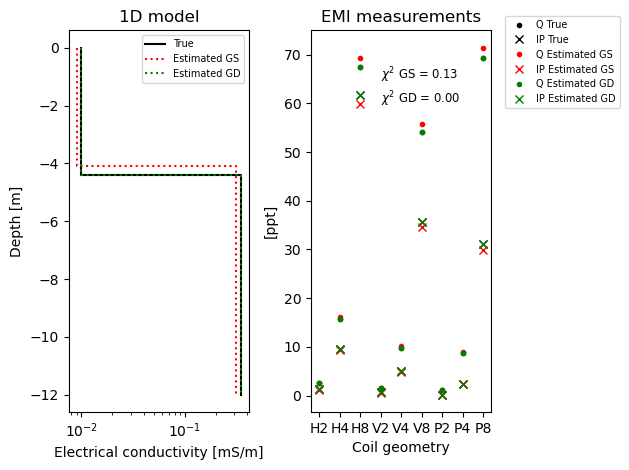

In [111]:
sigma_2Lay_est_gd_plot = np.hstack((model_2Lay_est_gd[:2], model_2Lay_est_gd[1]))
depths_2Lay_est_gd_plot = np.array([0, -model_2Lay_est_gd[2], dmax])

fig, ax = plt.subplots(1,2)

PlotModelData(sigma_2Lay_true_plot, depths_2Lay_true_plot, data_2Lay_true, model_name='True', data_name='True',
             ax=ax, data_style='k')
PlotModelData(sigma_2Lay_est_plot, depths_2Lay_est_plot, data_2Lay_est, model_name='Estimated GS', 
              data_name='Estimated GS', ax=ax, model_style=':r', data_style='r')
PlotModelData(sigma_2Lay_est_gd_plot, depths_2Lay_est_gd_plot, data_2Lay_est_gd, model_name='Estimated GD', 
              data_name='Estimated GD', ax=ax, model_style=':g', data_style='g')

ax[1].text(3, 65, '$\chi^2$ GS = '+ "{:1.2f}".format(rmse(data_2Lay_true, data_2Lay_est)), fontsize='small')
ax[1].text(3, 60, '$\chi^2$ GD = '+ "{:1.2f}".format(rmse(data_2Lay_true, data_2Lay_est_gd)), fontsize='small')

plt.savefig('figures/2Lay_Model_GS_GD', format='eps')

What if we add a 10 % noise

In [112]:
def NoiseAnalysis_2Lay_GD(data_true, noise=0.1, test_it=100):
    
    models = []
    for i in range(test_it):
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        
        # Initialize the forward modelling class 
        EMf = EMf_2Lay_Opt_HVP(lambd, height, offsets, freq, filt)

        # Define inversion framework from pygimli
        invEM = pg.Inversion()
        invEM.setForwardOperator(EMf) # set forward operator

        # Relative error array
        error = 1e-3 # relative error
        relativeError = np.ones_like(data_true[0]) * error

        # Start inversion
        models.append(invEM.run(data_noise, relativeError, verbose=False))

    return models
        
models_noise = NoiseAnalysis_2Lay_GD(data_2Lay_true)

15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 - 22:55:02 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.100000/3.000000
15/04/24 -

15/04/24 - 22:55:15 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


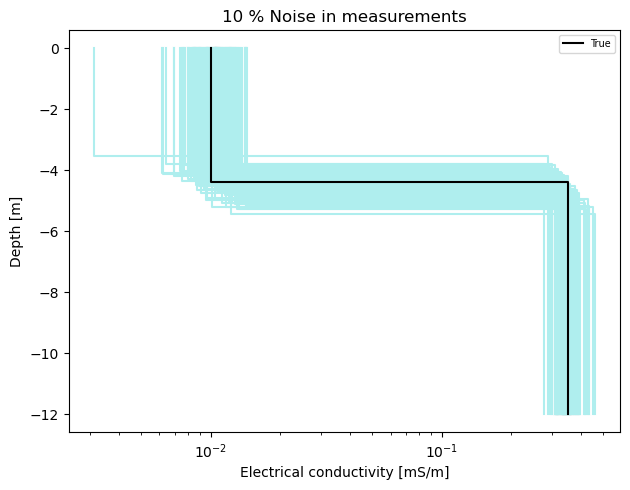

In [114]:
fig, ax = plt.subplots()

for m in range(len(models_noise)):
    mod = models_noise[m]
    sigma_2Lay_plot = np.hstack((mod[:2], mod[1]))
    depths_2Lay_plot = np.array([0, -mod[2], dmax])
    PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style='paleturquoise')
PlotModel(sigma_2Lay_true_plot, depths_2Lay_true_plot, model_name='True', ax=ax)

plt.title('10 % Noise in measurements') 
plt.savefig('figures/2Lay_Noise_GD', format='eps')

### Analysis of error space

In [115]:
# search the error space and output models with error < 0.2
err, models_err = ErrorSpace_2Lay(LU_2Lay, data_2Lay_est, 0.08, conds, thicks, nsl)

15/04/24 - 22:56:01 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


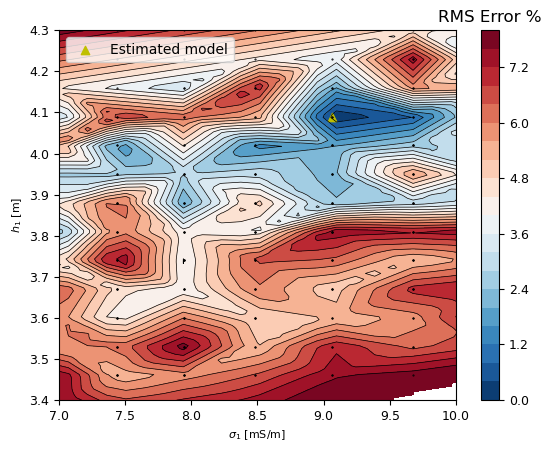

In [116]:
def PlotErrorSpace(model, model_est, err, models_err, depthmax=10):
      
    fig, ax = plt.subplots()
    
    x = (models_err[:,0])*1000 # conductivities of first layer in mS/m
    y = models_err[:,2]          # thickness of first layer
    z = err
    
    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)
    
    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    ax.contour(xi, yi, zi*100, levels=20, linewidths=0.5, colors='k')
    cntr1 = ax.contourf(xi, yi, zi*100, levels=20, cmap="RdBu_r")
    ax.plot(x, y, '.k', ms=1)
    ax.set(xlim=(7,10), ylim=(3.4,4.3))
    ax.scatter(((model_est[0])*1000), model_est[2],
                 marker ='^', c='y', label='Estimated model')
    ax.set_xlabel('$\sigma_1$ [mS/m]', fontsize=8)
    ax.set_ylabel('$h_1$ [m]', fontsize=8)
    ax.legend()
    ax.tick_params(axis='both',labelsize=9)
    #ax[0].tick_params(axis='both',labelsize=9)
    clb = fig.colorbar(cntr1, ax=ax)
    clb.ax.set_title('RMS Error %')
    clb.ax.tick_params(labelsize=9)

PlotErrorSpace(model_2Lay_true, model_2Lay_est, err, models_err)
plt.savefig('figures/2Lay_ErrorSpace', format='eps')